In [96]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, SequentialLR
import torch.nn.functional as F
import multiprocessing


if torch.backends.mps.is_available():
    device = torch.device("mps")  # GPU на Mac (Apple Silicon або AMD)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (не на Mac)
    print(
        f"GPU count: {torch.cuda.device_count()}"
        f", CUDA version: {torch.version.cuda}"
        f", cuDNN version: {torch.backends.cudnn.version()}"
    )
else:
    device = torch.device("cpu")  # fallback

print("Using GPU:", device)

GPU count: 1, CUDA version: 12.8, cuDNN version: 91002
Using GPU: cuda


In [97]:
PATH = "./CIFAR100.pth"

batch_size = 128
features = 100
num_workers = multiprocessing.cpu_count()
print("num_workers:", num_workers)

learning_rate = 1e-3
weight_decay = 1e-4

max_epochs = 200

num_workers: 12


In [98]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

train_dataset = torchvision.datasets.CIFAR100(
    root="./cifar100", download=True, transform=transform, train=True
)

test_dataset = torchvision.datasets.CIFAR100(
    root="./cifar100", download=True, transform=transform_test, train=False
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


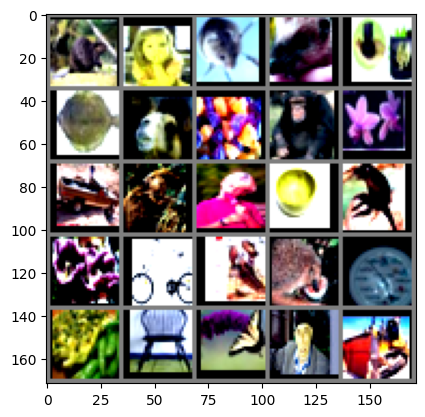

In [99]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, 
    shuffle=True, num_workers=num_workers
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, 
    shuffle=True, num_workers=num_workers
)


def showimg(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images[0:25], nrow=5)
showimg(img_grid)

In [100]:
class Cifar100Conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),
        )
        self.aap2 = nn.AdaptiveAvgPool2d(1)
        self.lin = nn.Sequential(
            nn.Linear(128, 256), nn.ReLU(), nn.Dropout(0.5), nn.Linear(256, 100)
        )

    def forward(self, x):
        out = self.conv(x)
        out = self.aap2(out)
        out = torch.flatten(out, 1)
        out = self.lin(out)
        return out

In [101]:
class VGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_l1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        self.conv_l5 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 1, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        self.fc = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, features),
        )

    def forward(self, x):
        out = self.conv_l1(x)
        out = self.conv_l2(out)
        out = self.conv_l3(out)
        out = self.conv_l4(out)
        out = self.conv_l5(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

In [102]:
train_losses, train_accuracies = [], []

model = torchvision.models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, features)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

linearLR = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=5)

cosine_annealingLR = CosineAnnealingLR(optimizer, T_max=max_epochs)

scheduler = SequentialLR(
    optimizer, [linearLR, cosine_annealingLR], milestones=[5]
)

n_total_steps = len(train_loader)

for epoch in range(max_epochs):
    train_loss, correct_train = 0, 0
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        loss_value = criterion(outputs, labels)
        loss_value.backward()

        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss_value
        train_loss += loss_value.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / len(train_dataset))

    scheduler.step()
    print(f"[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}")

print("Training finished")
torch.save(model.state_dict(), PATH)

[1] loss: 4.222
[2] loss: 3.822
[3] loss: 3.576
[4] loss: 3.383
[5] loss: 3.237


/home/alex/Документи/mnist/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


[6] loss: 3.119
[7] loss: 2.971
[8] loss: 2.863
[9] loss: 2.773
[10] loss: 2.693
[11] loss: 2.618
[12] loss: 2.558
[13] loss: 2.490
[14] loss: 2.435
[15] loss: 2.382
[16] loss: 2.328
[17] loss: 2.278
[18] loss: 2.227
[19] loss: 2.175
[20] loss: 2.131
[21] loss: 2.087
[22] loss: 2.042
[23] loss: 1.998
[24] loss: 1.953
[25] loss: 1.916
[26] loss: 1.862
[27] loss: 1.832
[28] loss: 1.784
[29] loss: 1.741
[30] loss: 1.713
[31] loss: 1.668
[32] loss: 1.630
[33] loss: 1.596
[34] loss: 1.569
[35] loss: 1.530
[36] loss: 1.492
[37] loss: 1.471
[38] loss: 1.438
[39] loss: 1.407
[40] loss: 1.388
[41] loss: 1.359
[42] loss: 1.337
[43] loss: 1.324
[44] loss: 1.302
[45] loss: 1.281
[46] loss: 1.268
[47] loss: 1.246
[48] loss: 1.232
[49] loss: 1.218
[50] loss: 1.206
[51] loss: 1.192
[52] loss: 1.175
[53] loss: 1.167
[54] loss: 1.150
[55] loss: 1.149
[56] loss: 1.132
[57] loss: 1.124
[58] loss: 1.116
[59] loss: 1.102
[60] loss: 1.099
[61] loss: 1.093
[62] loss: 1.084
[63] loss: 1.078
[64] loss: 1.068
[

In [103]:
load_model = torchvision.models.resnet18(weights=None)
load_model.fc = nn.Linear(load_model.fc.in_features, features)
load_model.to(device)
load_model.load_state_dict(torch.load(PATH))
load_model.eval()

with torch.no_grad():
    n_correct = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = load_model(images)

        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

    acc = n_correct / n_samples
    print(f"Accuracy of the network on the {n_samples} test image: {100*acc}%")

Accuracy of the network on the 10000 test image: 57.57%


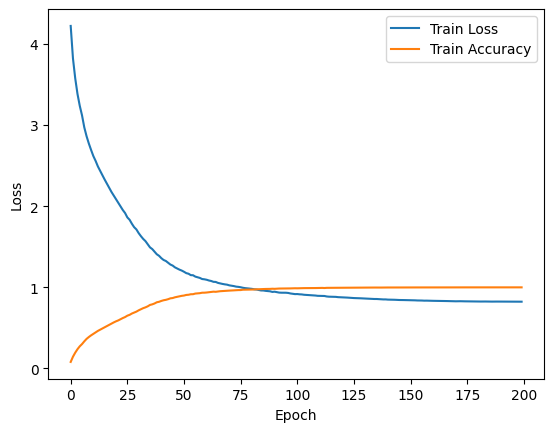

In [104]:
plt.plot(train_losses, label="Train Loss")
plt.plot(train_accuracies, label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()